In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()

# The Blasius boundary layer solution

## The Blasius Equation

The Prandtl equations on a flat plate are

$$ u \frac{\partial u}{\partial x}+ v \frac{\partial u}{\partial y} = \nu \frac{\partial^2 u}{\partial y^2} $$
$$ \frac{\partial u}{\partial x}+ \frac{\partial v}{\partial y} = 0. $$

We don't have an equation for $v$, so we use the stream function $\Psi$ to define the velocities as

$$ u = \frac{\partial \Psi}{\partial y}, \quad v = -\frac{\partial \Psi}{\partial x} $$

and automatically satisfy the continuity equation. 

From scaling arguments we know the boundary layer thickness $\delta$ scales as

$$ \frac\delta x \sim \frac 1 {\sqrt{Re_x}} $$

and 

$$ \frac u U = g\left(\frac y\delta\right) $$

for a laminar flat plate boundary layer. Therefore we choose

$$ \Psi = \sqrt{U \nu x}\enspace F(z), \quad z=y\sqrt{\frac U{\nu x}} $$

such that 

$$ u = UF'(z) $$

where $F'=\tfrac{\partial}{\partial z}F$. Substitution into the momentum equation and simplification gives the **Blasius equation**

$$ F''' +\frac 12 FF'' = 0 $$

with the boundary conditions $F(0) = F'(0) = 0$ and $F'(\infty)=1$.

---
##### Challenge Topic
##### Numerical Solution

There is no known solution for this equation, so we will approximate the solution numerically. The strategy is:

- Write the Blasius equation as a system of first order ODEs
- Integrate these ODEs numerically from $z=0\ldots\infty$. 
- Determine the wall boundary condition on $F''$ which satisfies $F'(\infty)=1$.

### First order-system

Numerical methods generally can't handle ODEs which have second and thrid derivatives in them. Luckily, there is a simple trick to remove these high-derivatives: we define two new variables as the derivatives of F, ie
$$ F'=G $$
$$ G'=H $$

Note that these are two new ODEs - each with only a first order derivative. Substituting these into the Blasius equation gives:

$$ H'= -\frac 12 F H $$

In this way, we have transformed the Blasius equation into an ODE system of three variables, $f=[F,G,H]$, and the first derivative of the system $f'$ is easily implemented as a python function:

In [2]:
import numpy
def fp(z,f):
    return numpy.array([f[1],f[2],-0.5*f[0]*f[2]])

### Numerical integration

Now that we've defined the system, we need to integrate it from $z=0\ldots\infty$. 

Well, actually, we'll use a numerical method to _approximate_ the integral for $z=[0,\Delta z,2\Delta z,\ldots, Z]$, where $\Delta z$ is size of the integration step, and $Z$ is a big enough number to stand in for $\infty$.

The function `blausius_int` takes in the initial condition `f(0)` and returns the velocity profile $u/U=F'=G$. 

In [3]:
from scipy.integrate import ode
dz = 0.05               # Step size
Z = 15                  # Integration limit

# integrate the Blausius ODEs
def blausius_int(f0):
    G = f0[1]
    r = ode(fp)
    r.set_initial_value(f0,0)
    while r.successful() and r.t < Z:
        r.integrate(r.t+dz)
        G = numpy.append(G,r.y[1])
    return G

### Initial conditions

Before we use this function, we need to set the initial conditions. The boundary conditions given above are $F_0=0$, $F'_0=G_0=0$ and $F'_\infty=G_\infty=1$. However, the integration method requires that we set $F''_0=H_0$, which is unknown. Let's guess $H_0 = 0$:

In [4]:
G = blausius_int([0,0,0])
"u_inf/U={Ginf}".format(Ginf=G[-1])

'u_inf/U=0.0'

Nope, this gives a value of $u_\infty/U$ that is too small. Let's try $H_0=1$:

In [5]:
G = blausius_int([0,0,1])
"u_inf/U={Ginf}".format(Ginf=G[-1])

'u_inf/U=2.08540824628'

Nope - too large. Instead of guess-and-checking by hand, we'll solve for the correct $H_0$ using a [bisect routine](http://en.wikipedia.org/wiki/Bisection_method). 

In [6]:
from scipy.optimize import bisect
H0 = bisect(lambda H0: blausius_int([0,0,H0])[-1]-1, 0, 1)

G = blausius_int([0,0,H0])
"H_0={H0}, u_inf/U={Ginf}".format(H0=H0, Ginf=G[-1])

'H_0=0.332057468152, u_inf/U=0.999999999999'

Let's see what this profile looks like:

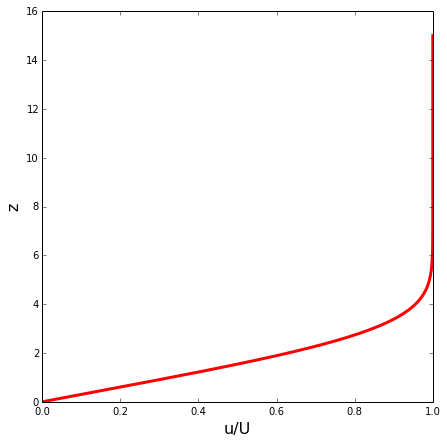

In [7]:
from matplotlib import pyplot
%matplotlib inline
size = 7

pyplot.figure(figsize=(size,size))
pyplot.xlabel('u/U', fontsize=16)
pyplot.ylabel('z', fontsize=16)
pyplot.plot(G,numpy.linspace(0,Z,len(G)), lw=3, c='r', label='Blasius')
pyplot.show()

The boundary conditions check out, and the profile looks good. This is the best approximation we can get to an exact boundary layer solution. 

## Blasius profile properties

### Boundary layer thickness: $\delta$

The far-field boundary condition states that $u/U=1$ only at $z=\infty$. However, the plot above shows that $u\approx U$ for fairly small values of $z$. We can query the values of the array to find a suitable cut-off:

In [8]:
i = 122
delB = (i-1)*dz
"u({z})/U={G}".format(z=delB,G=G[i-1])

'u(6.05)/U=0.999086759469'

$u/U=0.999$ at $z=y\sqrt{\frac U{\nu x}}\approx 6$. This is typically used as the Blasius boundary layer thickness - _but this is arbitrary_!

### Displacement and momentum thickness

Unlike $\delta$, the displacement thickness and momentum thickness values are finite, even when $u=U$ only at $z=\infty$. The definitions are

$$ \delta_1 = \int_0^\infty 1-\frac u U dy $$
$$ \delta_2 = \int_0^\infty \frac u U \left(1-\frac u U\right) dy $$

which we can evaluate numerically using the numpy `trapz` function:

In [9]:
def delta12(f,dz): # Print del1,del2
    del1 = numpy.trapz(1-f,dx=dz)
    del2 = numpy.trapz(f*(1-f),dx=dz)
    return (del1,del2,del1/del2)

["%0.3f" % j for j in delta12(G,dz)]

['1.721', '0.664', '2.591']

And we see $\delta_1 \sqrt{\frac U{\nu x}} \approx 1.7$,$\ $ $\delta_2\sqrt{\frac U{\nu x}} \approx 0.66$, and the shape factor $H = \delta_1/\delta_2 \approx 2.6$

---

## Comparison to polynomial profiles

We next compare the Blasius profiles to the linear, Karman (quadratic), and Pohlhausen (quintic) profiles.



First we compute the boundary layer thickness factor $\delta \sqrt{\frac U{\nu x}} = \sqrt{\frac{2f'(0)}F}$ where $f(\eta)$ is the polynomial defining the profile, $\eta=y/\delta$, and $F=\delta_2/\delta$.

In [10]:
def delta(f,deta):
    fp = (f[1]-f[0])/deta # Finite difference estimate of f'(0)
    F = numpy.trapz(f*(1-f),dx=deta)
    return numpy.sqrt(2*fp/F)

Since $z=\eta\delta\sqrt{\frac U{\nu x}}$, we can then use the `delta12` function defined above to compute the other thicknesses in terms of $z$.

In [11]:
row_format ="{:>10}"+"{:>8.3f}"*(4)
def delAndPrint(f,name):
    delf = delta(f,eta[1])
    print(row_format.format(name,delf,*delta12(f,eta[1]*delf)))
    return delf

Now we need only to define the profiles and compare:

In [12]:
eta = numpy.linspace(0.0,1.0,100)
karman = 2*eta-eta**2
pohlF = 2*eta-2*eta**3+eta**4

head_format =("{:>18}"+"{:>8}"*(3))
print(head_format.format("del","del_1","del_2","H"))
delL = delAndPrint(eta,"Linear")
delK = delAndPrint(karman,"Karman")
delP = delAndPrint(pohlF,"Pohlhausen")
print(row_format.format("Blasius",delB,*delta12(G,dz)))

               del   del_1   del_2       H
    Linear   3.464   1.732   0.577   3.000
    Karman   5.464   1.821   0.728   2.500
Pohlhausen   5.836   1.751   0.685   2.555
   Blasius   6.050   1.721   0.664   2.591


Other than the somewhat arbitrary $\delta$ value, these compare very well with the Blasius solution.

Finally, lets compare visually:

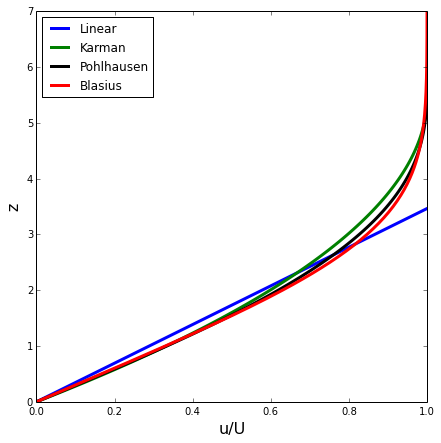

In [13]:
pyplot.figure(figsize=(size,size))
pyplot.axis([0,1,0,7])
pyplot.xlabel('u/U', fontsize=16)
pyplot.ylabel('z', fontsize=16)
pyplot.plot(eta,eta*delL, lw=3, label='Linear')
pyplot.plot(karman,eta*delK, lw=3, label='Karman')
pyplot.plot(pohlF,eta*delP, lw=3, color='k', label='Pohlhausen')
pyplot.plot(G,numpy.linspace(0,Z,len(G)), lw=3, label='Blasius')
pyplot.legend(loc='upper left')
pyplot.show()

We can see that both the second and forth order estimates are close to the Blasius profile, but that neither matches exactly. This indictes that while these profiles match the boundary conditions, they do not satisfy the Prandtl equations throughout the boundary layer.